 <style>
.cm-s-ipython .CodeMirror pre {
    font-size: 8pt; /* Adjust the font size*/
}
</style>

# **Homework 4:** The Hunt for the USS _Scorpion_
## HMMs, forwards-backwards, variable elimination
STATS348, UChicago, Spring 2024

----------------
**Daniel F. Noriega**

----------------

<a href="https://colab.research.google.com/github/aschein/stat_348_2024/blob/main/assignments/hw4/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

## Instructions

The purpose of this homework is to apply the ideas in lectures 7-9:
* probabilistic graphical models
* hidden Markov models (HMMs)
* variable elimination 
* belief propagation (BP) AKA the sum-product algorithm
* forwards-backwards algorithm (i.e., BP for HMMs).

Assignment is due **Wednesday April 24, 11:59pm** on GradeScope.

## Setting

You are back to searching for the missing submarine, the USS _Scorpion_.

As a reminder, it is May 1968 and the USS _Scorpion_ has just disappeared somewhere in the Atlantic Ocean, likely off the coast of Spain. You are the lone statistician on board the USS _Mizar_, which has been dispatched to find the missing submarine. Your job is to guide the search as best you can, given the data at your disposal.

## The search grid
The search grid will play a central role in this episode. The Navy has divided the search into a $(33 \times 26)$ grid of square-mile cells. The center of the grid is the rough location of loud acoustic event, likely an explosion, that was recorded around the time when the USS _Scorpion_ disappeared. The search grid, overlayed on a topographic map of the ocean floor is displayed below; the red dot is the rough location of the acoustic event.

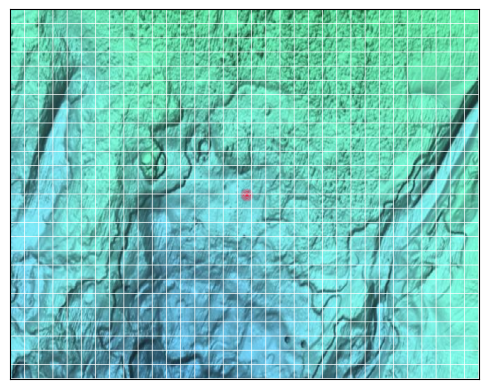

In [1]:
from hw_utils import plot_scorpion_search_grid, get_scorpion_search_grid
grid, img = get_scorpion_search_grid()
plot_scorpion_search_grid(grid, img)

### Cell coordinates versus cell indices

There are $K = 33 \times 26 = 858$ total cells in the grid. We can number each cell $k \in \{1,\dots,K\}$. Each cell therefore has an index $k$ as well as coordinates $(x,y)$ on the grid.

The `ravel_multi_index` and `unravel_index` functions let us map between these two.
See below for an explainer on these `numpy` functions.

In [2]:
import numpy as np
import numpy.random as rn

xy = (16, 12)
k = np.ravel_multi_index(xy, dims=(33, 26))
print(f'Cell {k} is in location {xy}')

k = 4
xy = np.unravel_index(k, shape=(33, 26))
print(f'Cell {k} is in location {xy}')

# this indexing system is based on the "ravel" operation

# consider the following 4d numpy array of random numbers
shape = (4,5,6,7)
arr = rn.random(shape)

# we can ravel this array, so that it is 1d
arr_raveled = arr.ravel()
assert arr_raveled.shape == (np.prod(shape),)

# the functions above let us map between the raveled index and the original multi-index
multi_index = (1, 2, 0, 5)
ravel_index = np.ravel_multi_index(multi_index, shape)
assert arr[multi_index] == arr_raveled[ravel_index]

ravel_index = 50
multi_index = np.unravel_index(ravel_index, shape)
assert arr[multi_index] == arr_raveled[ravel_index]

Cell 428 is in location (16, 12)
Cell 4 is in location (0, 4)


## Sonar blips
An unnamed intelligency agency has reported to us that its underwater listening stations detected an anomalous number of sonar blips occurring directly after the loud explosion in the same general area. The sonar blips may correspond to the USS _Scorpion_'s final movements after some catastrophic accident befell it. 

Based on the sonar data, and on the captain's expert opinion, we believe the _Scorpion_ was active for some period between 1-24 hours after the explosion, after which it likely sank. Define the following quantities:


\begin{align}
\nonumber t &=0 & &\textrm{ time of the explosion} \\
\nonumber T &= 24 & &\textrm{ max num. of hours before the sub sank} \\
\nonumber \tau &\in \{1,\dots, T\} & &\textrm{ (unknown) hour of sinking} \\
\nonumber Z_t &\in \{1, \dots, K\} & &\textrm{ what cell the sub was in at hour $t$} \\
\nonumber Z_T &\in \{1, \dots, K\} & &\textrm{ the sub's final resting place (where it is now)} \\
\end{align}


## Possible scenarios
We convened a panel of submarine experts to imagine what might have happened in the hours between the explosion and when the sub ultimately sank. 

They imagined $6$ possible scenarios that could have plausibly occurred.

| Scenario $s$    | Description | Expected hours alive $\mathbb{E}[\tau \mid s]$ | Prior probability of scenario $P(s)$ |
| ----------- | ----------- | ----------- | ----------- | 
| flounder    | The _Scorpion_ suffered a catastrophic malfunction; it moved aimlessly before sinking quickly. | 4 | 0.35 | 
| drift       | The _Scorpion_ suffered a catastrophic malfunction; it drifted East with the tide before sinking quickly. | 6 | 0.2 |
| reverse course  | The _Scorpion_ suffered a major malfunction; it reversed course back to base (Northeast), and sailed for a while before sinking. | 12 | 0.15 |
| seek shallow  | The _Scorpion_ suffered a major malfunction; it sought shallower waters, and sailed for a while before sinking. | 6 | 0.1 |
| evade   | The _Scorpion_ was seriously damaged by an enemy attack; it took evasive maneuvers, moving unpredictably and changing course often, but sank soon after.    | 4 | 0.1 |
| seek ridge   | The _Scorpion_ was lightly damaged by an enemy attack; it manuevered quickly into an underwater ridge for cover, but collided with the narrow ridge and sank. | 12 | 0.1 |

The experts have assigned each scenario a prior probabability $P(S=s)$ for $s \in \mathcal{S} \equiv \{\textrm{flounder}, \textrm{evade},\dots\}$.

They have also constructed a prior over the hour-of-sinking $\tau$ under each scenario. Since they strongly believe the sub could not have survived longer than 24 hours, the prior is binomial with $T=24$:
\begin{align}
P(\tau \mid s) = \textrm{Binom}(\tau;\,T,\, \rho_s),\,\,\, \tau \in \{0,1,2,\dots,T\}
\end{align}
where $\rho_s \in (0,1)$ and $\mathbb{E}[\tau \mid s] = T\rho_s$ 

We have implemented the expert's prior in the code below. The function `get_tau_prior` takes $T$ and $(\rho_s)_{s \in \mathcal{S}}$ and uses [closure](https://www.learnpython.org/en/Closures) to define and return a conditional function `tau_prior` which will return $P(\tau \mid s)$ for an input scenario $s$.

In [3]:
import pandas as pd
import scipy.stats as st

df_scenarios = pd.DataFrame()
df_scenarios['scenario'] = ['flounder', 'drift', 'reverse_course', 'seek_shallow', 'evade', 'seek_ridge']
df_scenarios['rho_s'] = [4./24, 6./24, 12./24, 6./24, 4./24, 12./24]
df_scenarios['p(s)'] = [0.35, 0.2, 0.15, 0.1, 0.1, 0.1]

def get_tau_prior(max_timesteps, rho_dict):
    def tau_prior(scenario):
        rho = rho_dict[scenario]
        return st.binom(max_timesteps, rho).pmf(np.arange(max_timesteps+1))
    return tau_prior

rho_dict = df_scenarios.set_index('scenario').to_dict()['rho_s']
tau_prior = get_tau_prior(max_timesteps=24, rho_dict=rho_dict)

You can interact with `tau_prior` in the following way.

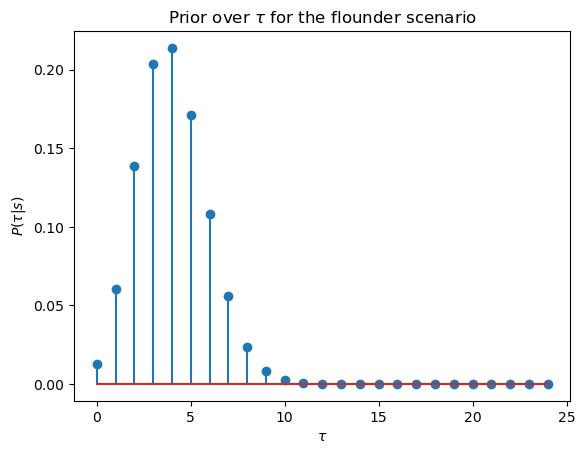

In [4]:
import matplotlib.pyplot as plt
P_tau_given_flounder = tau_prior('flounder')
assert P_tau_given_flounder.shape == (25,) and np.allclose(P_tau_given_flounder.sum(), 1)

# _ = plt.stem(P_tau_given_flounder, use_line_collection=True)
_ = plt.stem(P_tau_given_flounder)
_ = plt.xlabel('$\\tau$')
_ = plt.ylabel('$P(\\tau | s)$')
_ = plt.title('Prior over $\\tau$ for the flounder scenario')

## A scenario-based Markov model

For each of the 6 scenarios, the experts have also put together a simple model of the _Scorpion_'s likely movements while it was still alive. Each model is a _Markov model_, which posits the following transition behavior that conditions on the scenario $s$ and time-of-death $\tau$:

For $t=1,\dots, T$:
\begin{align}
P_{s, \tau}(Z_t = k \mid Z_{t-1} = j) &= 
\begin{cases}
\Lambda_s(j, k) & \textrm{if }t \leq \tau \\
0 & \textrm{if }t > \tau \textrm{ and } j \neq k \\
1 & \textrm{if }t > \tau \textrm{ and } j = k \\
\end{cases}
\end{align}

For $t=0$:
\begin{align}
P(Z_0 = k) &= \pi_0(k)
\end{align}

$\pi_0 \in (0,1)^K$ is the _initial distribution_ over cells where the _Scorpion_ may have been at $t=0$.

$\Lambda_s \in (0,1)^{K \times K}$ is a row-stochastic _transition matrix_, where the rows sum to 1:

\begin{align}
\sum_{k=1}^K \Lambda_s(j, k) = 1,\,\,\forall j
\end{align}

There is a different transition matrix $\Lambda_s$ for each scenario $s$; each one describes a different pattern of movement. You can load them using `pickle` below.

In [5]:
import pickle
with open('transition_matrices.pkl', 'rb') as f:
    transition_matrices = pickle.load(f)

print(transition_matrices.keys())
assert all(transition_matrices[s].shape == (858, 858) for s in transition_matrices.keys())

dict_keys(['flounder', 'evade', 'drift', 'reverse_course', 'seek_shallow', 'seek_ridge'])


We also provide functions to simulate paths with a given transition matrix and to plot the path on the search grid. 

You can play with them to see what kinds of paths are typical under each scenario.

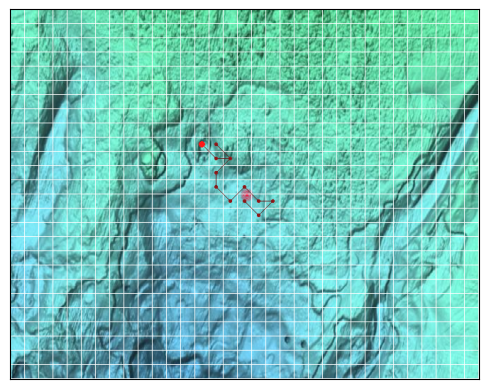

In [6]:
from hw_utils import plot_scorpion_path

def sample_markov(transition_matrix,  n_timesteps=10, start_cell=428):
    """ Sample a path from a Markov chain with the given transition matrix.

    Parameters
    ----------
    transition_matrix : np.ndarray
        A square matrix of shape (n_cells, n_cells) where n_cells is the number of cells in the grid.
        The (i,j) entry of this matrix is the probability of transitioning from cell i to cell j.
    n_timesteps : int
        The number of timesteps to sample.
    start_cell : int
        The index of the cell to start the path from.
        Default value is 428, corresponding to (16,12) on the grid, where the explosion occurred.
    """
    n_cells = transition_matrix.shape[0]

    path = [start_cell]
    for _ in range(n_timesteps):
        next_cell = rn.choice(n_cells, p=transition_matrix[path[-1]])
        path.append(next_cell)
    return path

path = sample_markov(transition_matrices['evade'], n_timesteps=12)
path = [np.unravel_index(k, shape=(33, 26)) for k in path]  # convert to (x,y) coordinates
plot_scorpion_path(path, show=True)

You can load the initial distribution $\pi_0 \in (0,1)^K$ below using `numpy.load`.

We have provided a function to plot probability distributions over the search grid.

This function will darken cells proportional to their probability under the distribution.

For instance, if $\pi_0(k) \approx 0$, then cell $k$ will be black.


The function requires you to first `reshape` the distribution into a 2d array where the (row,col) indices match the $(x,y)$-coordinates on the grid.

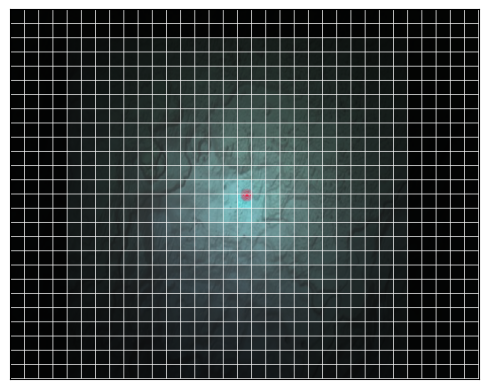

In [7]:
from hw_utils import plot_dist_on_scorpion_search_grid

initial_dist_K = np.load('initial_dist.npy') # \pi_0
assert initial_dist_K.shape == (858,)

plot_dist_on_scorpion_search_grid(dist=initial_dist_K.reshape((33, 26)), show=True)

## Sonar likelihood

As mentioned before, underwater listening stations picked up an anomalous pattern of sonar blips in the hours after the explosion.

There were $D$ listening devices in the area. Let $u_d \in \{1,\dots, K\}$ be the cell location of the $d^{\textrm{th}}$ device.

Assume the following conditional likelihood for $t \in \{1,\dots, T\}$ and sonar station $d \in \{1, \dots, D\}$. This likelihood conditions on the location $Z_t=z_t$ of the sub at time $t$, as well as on the hour-of-sinking $\tau$.
$
\begin{align}
P(x_{t,d} \mid Z_t=k,\, \tau) &= \begin{cases}
\textrm{Pois}(x_{t,d};\, \mu_{d,0} + \mu_d(z_t)) & &\textrm{if } t \leq \tau \\
\textrm{Pois}(x_{t,d};\, \mu_{d,0}) & &\textrm{if } t > \tau
\end{cases}
\end{align}
$
where $\mu_d(z_t) = \gamma_d \, \exp\left(-\tfrac{1}{2}\,\textrm{dist}(z_t, u_d)\right)$. Here, $\textrm{dist}(z_t, u_d)$ is the distance between the sub at $t$ and listening cell $d$, and $\gamma_d$ is a parameter that is fixed and known. 

$\mu_{0,d}$ is the background rate of sonar blips for device $d$; it is also fixed and known.

It is also useful to define the *likelihood vector* at time $t$, conditional on $\tau$; this is:
$$
\begin{align}
\boldsymbol{\ell}^{\tau}_{t} &= \begin{bmatrix}
           P_\tau({\boldsymbol{x}}_{t} \mid Z_t=1) \\
           P_\tau({\boldsymbol{x}}_{t} \mid Z_t=2) \\
           \vdots \\
           P_\tau({\boldsymbol{x}}_{t} \mid Z_t=K)
         \end{bmatrix}
  \end{align}
$$
An element of it is $\ell^{\tau}_{t}(k) = P_\tau(\boldsymbol{x}_{t} \mid Z_t=k) \equiv \prod_{d=1}^D P(x_{t,d} \mid Z_t=k,\, \tau)$.

For your convenience, we have implemented the following function `get_sonar_likelihood`. It takes in the grid shape, the listening device locations $(u_d)_{d=1}^D$, and the parameters $(\mu_{0,d},\gamma_d)_{d=1}^D$, and then uses [closure](https://www.learnpython.org/en/Closures) to define and return a conditional function `sonar_likelihood` that will return a 2-d table $(\boldsymbol{\ell}^{\tau}_{t})_{t=1}^T$ for a given $\tau$.

(You do not need to study the details of this function as long as you understand the input and output of `sonar_likelihood`.)

In [8]:
import scipy.stats as st

def distance_between_cells(k1, k2, grid_shape=(33, 26)):
    x1, y1 = np.unravel_index(k1, grid_shape)
    x2, y2 = np.unravel_index(k2, grid_shape)
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def get_sonar_likelihood(grid_shape, u_D, mu0_D, gam_D):
    n_stations = len(u_D)
    assert n_stations == mu0_D.size == gam_D.size

    # possible values of Z_t (0-indexed, so 0...K-1)
    n_cells = np.prod(grid_shape)

    # compute distance between each listening station and every other cell in the grid
    distances_DK = np.zeros((n_stations, n_cells))
    for d, k in np.ndindex((n_stations, n_cells)):
        distances_DK[d, k] = distance_between_cells(u_D[d], k)
    
    # define a likelihood function that will output the likelihood table, for a given tau
    def sonar_likelihood(sonar_data, tau):
        assert sonar_data.ndim == 2
        n_timesteps, n_stations = sonar_data.shape
        assert 0 <= tau <= n_timesteps   

        Mu_TKD = np.ones((n_timesteps, n_cells, n_stations)) * mu0_D
        if tau > 0:
            Mu_TKD[:tau] += gam_D * np.exp(-0.5 * distances_DK.T)

        L_TK = st.poisson.pmf(sonar_data[:, None, :], Mu_TKD).prod(axis=-1)

        return L_TK

    return sonar_likelihood

We can now load in the parameters of the listening devices $(u_d, \mu_{0,d}, \gamma_d)_{d=1}^D$ and use them to define a likelihood.

In [9]:
arrays = np.load('listening_stations.npz')
# the cell indices of each listening device
u_D = arrays['u_D']
# the background rate of each listening device \mu_{0,d}
mu0_D = arrays['mu0_D']
# the parameter \gamma_{d} for each listening device
gam_D = arrays['gam_D']

# define a likelihood function for these parameters
sonar_likelihood = get_sonar_likelihood((33, 26), u_D, mu0_D, gam_D)

And finally, we can load in the sonar data $\boldsymbol{x}_{1:T}$, and evaluate its likelihood for different values of $\tau$:

In [10]:
# load in the sonar data
sonar_data = np.load('sonar_data.npy')
assert sonar_data.shape == (24, len(u_D))

# compute the likelihood table for tau=0
L_TK = sonar_likelihood(sonar_data, tau=0)
assert L_TK.shape == (24, 858)

# compute the likelihood table for tau=24
L_TK = sonar_likelihood(sonar_data, tau=24)
assert L_TK.shape == (24, 858)

## Question 1 [Visualize] (10pts)

Create a directed graphical model for the joint distribution:

$$P(s, \tau, \boldsymbol{z}_{0:T}, \boldsymbol{x}_{1:T})$$

You do not need to visualize the parameters $\{\pi_0, \left(\Lambda_s, \rho_s\right)_{s \in \mathcal{S}}, (u_d,\mu_{0,d},\gamma_d)_{d=1}^D\}$.

You may use the [TikZ package](https://www.overleaf.com/learn/latex/TikZ_package), an illustrator like Omnigraffle, or a slides-maker like Keynote/Powerpoint. You can also handwrite and scan it, so long as it is very neat and readable.

Please insert your figure below:
___



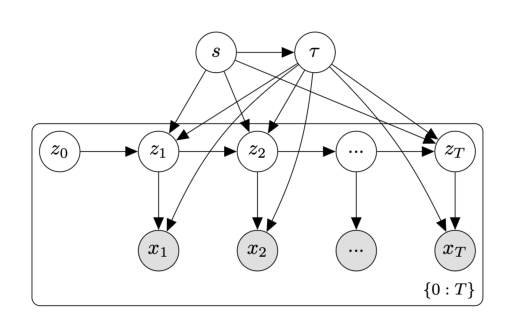

In [11]:
from PIL import Image
t_img = Image.open('diagram_dfn.png')
plt.imshow(t_img)
plt.axis('off')
plt.show()

___

## Question 2 [Code] (10pts)

The **forward pass** in this case can be defined by the following recursion. For $t=2,\dots,T$:

$$\alpha_t^{\tau,s}(k) = \sum_{j=1}^K \, P_{s, \tau}(Z_t=k \mid Z_{t-1}=j) \, P_\tau({\boldsymbol{x}}_{t-1} \mid Z_{t-1}=j) \, \alpha_{t-1}^{\tau,s}(j)$$

where the base case of the recursion is $t=1$:
$$\alpha_1^{\tau,s}(k) = \sum_{j=1}^K \, P_{s, \tau}(Z_1=k \mid Z_{0}=j) \, P(Z_0 = j)$$

(There are other ways to define the forward pass, but this is one.)

Implement the **forward pass** for a given scenario $s$ and hour-of-sinking $\tau$, by filling in the code for the method below.

- When implementing the forward pass, do not use nested for-loops. Your code should contain **only a single for-loop over $t$** and otherwise involve only matrix-vector operations.

- **NOTE**: it is sometimes convenient to compute the forward pass an extra step to $t=T+1$ (e.g., for **predictive** problems, involving $Z_{T+1}$); the method below takes as an argument a flag indicating whether to compute to $T$ or $T+1$.

- **NOTE:** Python **zero-indexes**, so the mathematical expression $t=1$ will translate to the software expression `t=0`.

In [12]:
def forward_pass(tau, transition_matrix_KK, initial_dist_K, likelihood_TK, predictive=False):
    """ Compute the forward pass of the HMM for a given tau and scenario.
    
    Parameters
    ----------
    tau : int
        The time-of-sinking for the USS Scorpion: 0...24.
    transition_matrix_KK : np.ndarray
        A (KxK) row-stochastic matrix for a given scenario.
    initial_dist_K : np.ndarray
        A (K,) vector representing the initial distribution over cells.
    likelihood_TK : np.ndarray
        A (TxK) matrix of likelihood values for the sonar data, for a given tau.
    predictive : bool
        If True, compute the forward messages to T+1.
        If False, compute the forward messages to T.
    Returns
    -------
    alpha_TK : np.ndarray
        A (TxK) or (T+1xK) matrix of forward messages
    """
    T, K = likelihood_TK.shape
    assert 0 <= tau <= T
    T_ = T + 1 if predictive else T
    
    alpha_TK = np.zeros((T_, K))
    
    #Initialize the base case
    alpha_TK[0]=transition_matrix_KK.T @ initial_dist_K

    #Iterate through time
    for t in range(1,T_):
        if t <= tau:
            alpha_TK[t]=(transition_matrix_KK.T @ alpha_TK[t-1])*likelihood_TK[t-1]
        else:
            alpha_TK[t]=alpha_TK[t-1]*likelihood_TK[t-1] # Reflects behavior post-sinking


    return alpha_TK

## Question 3 [Math, code] (5pts)

Provide a way to compute the following **filtering probability** using the forward pass $\alpha_t^{\tau,s}(k)$ values.

$$ 
P(Z_T = k \mid s, \tau, \boldsymbol{x}_{1:T}) = ?
$$

___

To compute the probability we can normalize the $\alpha$ values at the final time step T by their sum. So that:

$$
    P(Z_T = k | s, \tau, x_{1:T}) = \frac{\alpha_T^{\tau,s}(k)}{\sum_{j=1}^K \alpha_T^{\tau,s}(j)}
$$

where $\alpha_T^{\tau,s}(k)$ is the forward message at time T for state k.
___

Then use your implementation of the forward pass to compute and visualize $P(Z_T = k \mid s, \tau, \boldsymbol{x}_{1:T})$ for the four combinations of $(s,\tau)$ given. (Your code should use `forward_pass` to compute `P_Z`.)


Probability distribution for scenario seek_ridge and tau = 5


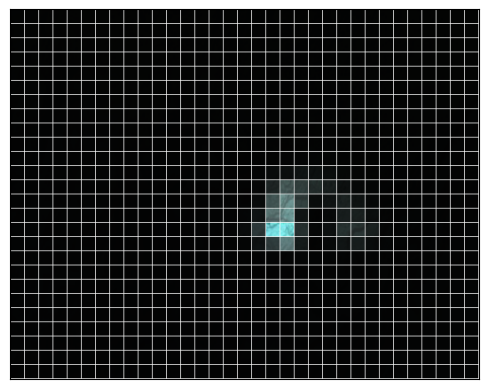


Probability distribution for scenario seek_ridge and tau = 24


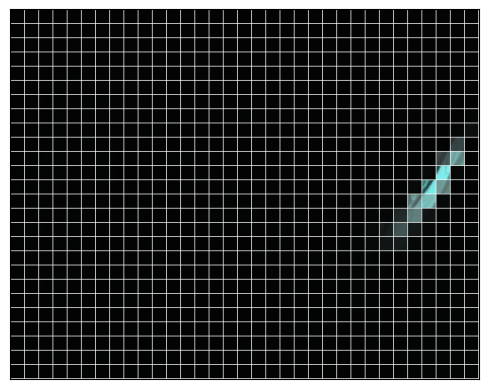


Probability distribution for scenario flounder and tau = 5


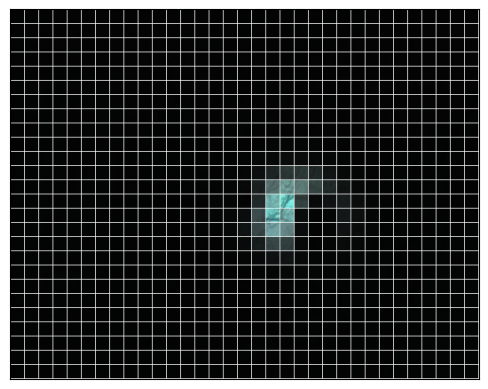


Probability distribution for scenario flounder and tau = 24


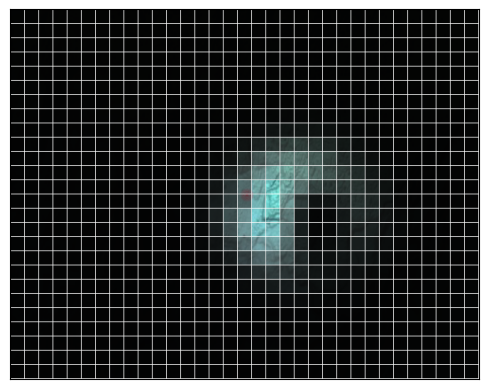

In [13]:
for s in ['seek_ridge', 'flounder']:
    for tau in [5, 24]:
        
        #Get the transition matrix for the scenario
        temp_transition_matrix = transition_matrices[s]

        #Execute the forward pass
        temp_alpha = forward_pass(tau, temp_transition_matrix, initial_dist_K, L_TK, predictive=True)
        temp_alpha = temp_alpha[-1]
        P_Z = temp_alpha / np.sum(temp_alpha)

        assert P_Z.shape == (858,) and np.allclose(P_Z.sum(), 1)
        
        print('\nProbability distribution for scenario', s, 'and tau =', tau)
        plot_dist_on_scorpion_search_grid(P_Z.reshape((33, 26)), show=True)

## Question 4 [Code] (10pts)

The backward pass is defined by the following recursion for $t=T-1,\dots, 0$:

$$
\beta^{\tau, s}_t(k) = \sum_{j=1}^K P_{s,\tau}(Z_{t+1}=j \mid Z_{t}=k)\, P_\tau({\boldsymbol{x}}_{t+1} \mid Z_{t+1}=j) \, \beta^{\tau, s}_{t+1}(j)
$$

where the base case of the recursion is for $t=T$:
$$\beta^{\tau, s}_T(k) = 1$$

Implement the backward pass.
- Again, your code should contain **only a single for-loop over $t$** and otherwise involve only matrix-vector operations.

- Again, be mindful of **zero-indexing**.

In [14]:
def backward_pass(tau, transition_matrix_KK, likelihood_TK):
    """ Compute the forward pass of the HMM for a given tau and scenario.
    
    Parameters
    ----------
    tau : int
        The time-of-sinking for the USS Scorpion: 0...24.
    transition_matrix_KK : np.ndarray
        A (KxK) row-stochastic matrix for a given scenario.
    initial_dist_K : np.ndarray
        A (K,) vector representing the initial distribution over cells.
    likelihood_TK : np.ndarray
        A (TxK) matrix of likelihood values for the sonar data, for a given tau.
    
    Returns
    -------
    beta_TK : np.ndarray
        A (TxK) matrix of backward messages
    """
    
    T, K = likelihood_TK.shape

    #Initializing beta
    beta_TK = np.zeros((T,K))

    #Setting the base case
    beta_TK[-1]=np.ones(K)

    #Iterating through time
    for t in range(T-2,-1,-1):
        if t > tau:
            beta_TK[t] = beta_TK[t+1]*likelihood_TK[t+1] # Behavior post-sinking
        else:
            beta_TK[t] = transition_matrix_KK @ (beta_TK[t+1]*likelihood_TK[t+1]) #Pre-sinking

    return beta_TK

## Question 5 [Math, code] (5pts)

Provide a way to compute the following **smoothing probability** using the forward ($\alpha$) and backward ($\beta$) values.

$$ 
P(Z_t = k \mid s, \tau, \boldsymbol{x}_{1:T}) = ?
$$

___

To compute the **smothing probability** we can combine the forward and backward probabilities to get a marginal for $P(Z_t=k|s,\tau,x_{1:T})$, so that:

$$
    P(Z_t=k|s,\tau,x_{1:T}) = \frac{\alpha_t^{s, \tau}(k)\cdot \beta_t^{s, \tau}(k)}{\sum_{j=1}^K \alpha_t^{s, \tau}(j)\cdot \beta_t^{s, \tau}(j)}
$$

Because $\alpha_t(k)$ represents the probability of being in $k$ at time $t$ given observations $1:t$, while $\beta_t(k)$ represent the probability of observing the 'future' data from $t+1:T$ given $k$ at time $t$. (Normalize to ensure that probabilities sum to 1 across all $k$)

___

Then use your implementation of the forward and backward pass to compute and visualize the distribution $P(Z_t = k \mid s, \tau, \boldsymbol{x}_{1:T})$ for hour $t=15$ and the four combinations of $(s,\tau)$ given. (Your code should use `forward_pass` to compute `P_Z`.)


Probability distribution for reverse_course scenario at hour 15 and tau=5:


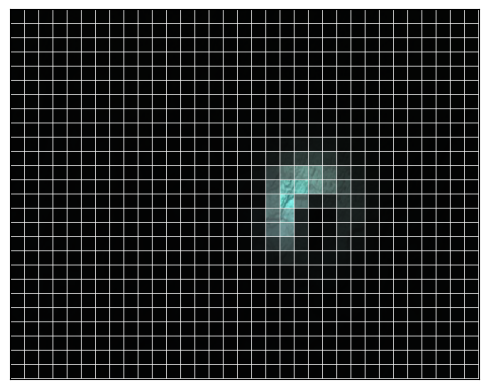


Probability distribution for reverse_course scenario at hour 15 and tau=24:


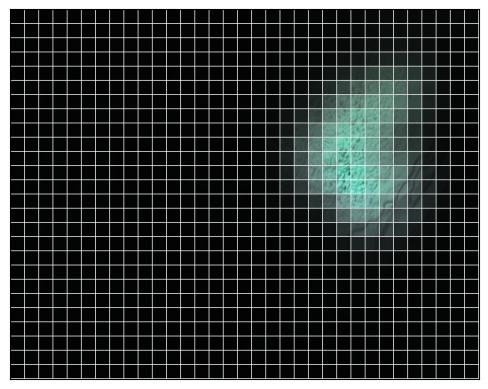


Probability distribution for flounder scenario at hour 15 and tau=5:


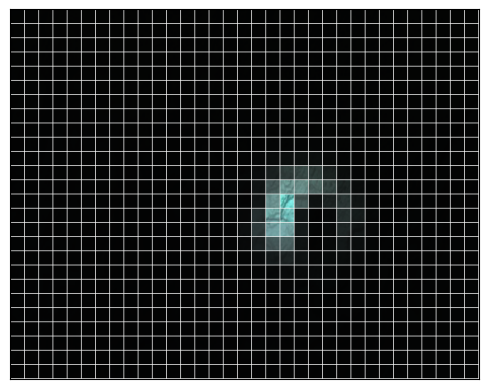


Probability distribution for flounder scenario at hour 15 and tau=24:


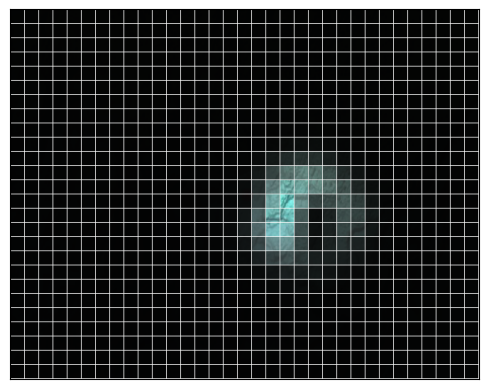

In [15]:
tau_vals = [5, 24]
s_vals = ['reverse_course', 'flounder']
for s in s_vals:
    #Get the transition matrix for the scenario
    temp_transition_matrix = transition_matrices[s]
    for tau in tau_vals:
        hour=15
        
        #Execute the forward pass
        temp_alpha = forward_pass(tau, temp_transition_matrix, initial_dist_K, L_TK, predictive=True)
        temp_alpha = temp_alpha[hour-1]

        #Execute the backward pass
        temp_beta = backward_pass(tau, temp_transition_matrix, L_TK)
        temp_beta = temp_beta[hour-1]

        #Compute the Smoothing Probability
        P_Z = (temp_alpha*temp_beta)/np.sum(temp_alpha*temp_beta)
        
        print(f'\nProbability distribution for {s} scenario at hour {hour} and tau={tau}:')
        plot_dist_on_scorpion_search_grid(P_Z.reshape((33, 26)).copy(), show=True)

## Question 6 [Math] (20pts) 

All of the previous calculations conditioned on a specific scenario $s$ and hour-of-sinking $\tau$.

Now, derive an algorithm to exactly compute the following probability distribution for any $t$:

$$P(Z_t = k \mid \boldsymbol{x}_{1:T})$$

- Your algorithm **should involve the forwards and backwards pass** as a subroutine.

- Use the space below to state your algorithm and provide enough detail for someone to implement it exactly, and enough detail to show how you derived it.
___

**Marginalizing Over Scenarios and Sinking Times**

Since the previous calculations conditions on specific $s$ and $\tau$, to eliminate this conditioning we need to marginalize over all $s$,$\tau$. This means summing over the joint probabilities of $s$, $\tau$, and $Z_T=k$ given all observations $x_{1:T}$, weighted by the probabilities of $s$ and $\tau$. In other words:

$$
    P(Z_t=k| x_{1:T}) = \sum_s \sum_\tau P(Z_t=k|s,\tau,x_{1:T})\cdot P(\tau, s | x_{1:T})
$$

**Computing Components**

1. Smoothing Probability $P(Z_t=k|s,\tau,x_{1:T})$

    As discussed in previous answers:

    $$P(Z_t=k|s,\tau,x_{1:T}) = \frac{\alpha_t^{s, \tau}(k)\cdot \beta_t^{s, \tau}(k)}{\sum_{j=1}^K \alpha_t^{s, \tau}(j)\cdot \beta_t^{s, \tau}(j)}$$

    where $\alpha$ and $\beta$ are calculated from the forward and backward passes, respectively.

2. Posterior Distribution of $s$ and $\tau$

    We will use Bayesian updating:

    $$P(\tau, s | x_{1:T}) \propto P(x_{1:T}|s, \tau) \cdot P(\tau|s) \cdot P(s)$$

    where $P(x_{1:T}| s, \tau)$ can be computed by summing over all paths that the HMM can take under scenario $s$ and sinking time $\tau$.

    Note that $P(x_{1:T | s,\tau})$ is essentially:

    $$P(x_{1:T} | s,\tau) = \sum_{j=1}^K \alpha_T^{s, \tau}(j)$$

### **Algorithm**

#### 1. Precompute:

* Use $P(s)$ given by expert opinion:

    Note that the experts have assigned each scenario a prior probabability $P(S=s)$ for $s \in \mathcal{S} \equiv \{\textrm{flounder}, \textrm{evade},\dots\}$.

* Use $P(\tau|s)$:

    Experts have also constructed a prior over the hour-of-sinking $\tau$ under each scenario. A binomial with $T=24$:
\begin{align}
P(\tau \mid s) = \textrm{Binom}(\tau;\,T,\, \rho_s),\,\,\, \tau \in \{0,1,2,\dots,T\}
\end{align}
where $\rho_s \in (0,1)$ and $\mathbb{E}[\tau \mid s] = T\rho_s$ (given)

* For each $s$ and $\tau$, run the forward and backward passes to compute $\alpha$ and $\beta$.

#### 2. Calculate Posterior Probabilities:

* For each scenario $s$:

    * For each sinking time $\tau$:

        * Compute $P(Z_t=k|s,\tau,x_{1:T})$ using the forward pass results

        * Update the posteriors:

        $$
            P(\tau , s| x_{1:T}) \propto P(x_{1:T}|s, \tau) \cdot P(\tau|s) \cdot P(s)
        $$
        
        * Normalize $P(\tau, s | x_{1:T})$ over all $s$ and $\tau$. (Note that one should normalize over all $s$ and all $\tau$)

#### 3. Compute $P(Z_t=k|x_{1:T}$):

* For each time $t$:

    * For each position $k$:

        * Calculate the unnormalized probability:

        $$
            P(Z_t=k| x_{1:T})_{raw} = \sum_s \sum_\tau P(Z_t=k|s,\tau,x_{1:T})\cdot P(\tau, s | x_{1:T})
        $$

* Ensure $P(Z_t=k|x_{1:T})$ sums to $1$ over all $k$ for each $t$. So, adjust by:

$$
    \textit{For each t:} \quad P(Z_t=k|x_{1:T}) = \frac{P(Z_t=k|x_{1:T})_{raw}}{\sum_{j=1}^K P(Z_t=j|x_{1:T})_{raw}}
$$


---

## Question 7 [Code] (10pts) 

Implement your answer to Question 6, and then run it for $t=0$ and $t=T$ so that it computes the following two marginals:
$$P(Z_0 = k \mid \boldsymbol{x}_{1:T})$$
$$P(Z_T = k \mid \boldsymbol{x}_{1:T})$$
which are the posteriors over where the _Scorpion_ was initially ($Z_0$), and as well as its final resting place ($Z_T$).

- Your code below should involve calls to both `forward_pass` and `backward_pass`.

- It should ultimately produce `posterior_Z_T` and `posterior_Z_0` (which are the two marginals) and then plot them over the grid.

- Make sure both plots are visible.


Posterior distribution at time 0


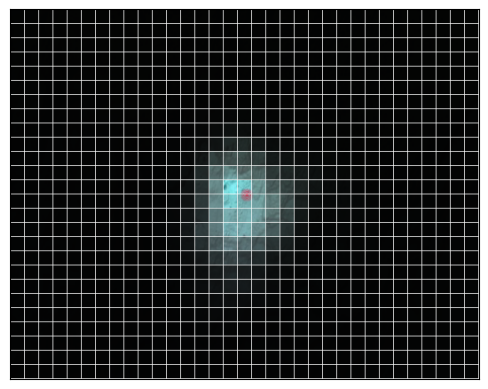


Posterior distribution at time T


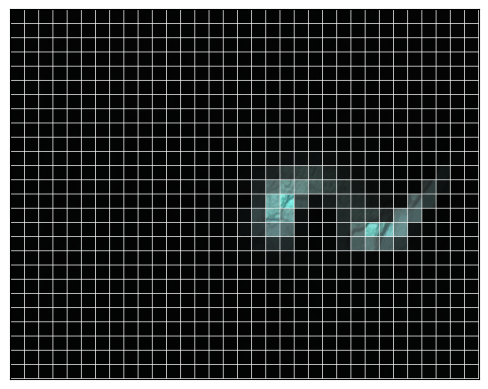

In [16]:
T, K = L_TK.shape

# Initialize dict to store scenario results
scenarios_store = []

# I will also save scenario probabilities for later analysis (question 8)
scenario_probabilities = np.zeros(len(df_scenarios)) # 8

# Iterate through scenarios, computing the forward and backward passes
# Updating the posteriors over tau and s
for i, r in df_scenarios.iterrows():
    s = r['scenario']
    prob_s = r['p(s)']
    tau_probs=tau_prior(s)
    temp_transition_matrix = transition_matrices[s]

    for tau, p_tau_s in enumerate(tau_probs):
        temp_alpha = forward_pass(tau, temp_transition_matrix, initial_dist_K, L_TK, predictive=False)
        temp_beta = backward_pass(tau, temp_transition_matrix, L_TK)
        posterior_tau_s = (np.sum(temp_alpha[-1])*prob_s)*p_tau_s
        scenarios_store.append((posterior_tau_s, temp_alpha, temp_beta))

        # Save scenario probabilities for later analysis (question 8)
        scenario_probabilities[i]+=posterior_tau_s # 8
        
#For normalizing posteriors over tau and s
total_posterior_tau_s = sum([x[0] for x in scenarios_store])

# Initialize posteriors to store the results
posterior_Z_0 = np.zeros(K)
posterior_Z_T = np.zeros(K)

for tposterior, talpha, tbeta in scenarios_store:
    posterior_Z_0+=talpha[0]*tbeta[0]*tposterior/total_posterior_tau_s
    posterior_Z_T+=talpha[-1]*tbeta[-1]*tposterior/total_posterior_tau_s

# Normalize the posteriors over Z
posterior_Z_0=posterior_Z_0/np.sum(posterior_Z_0)
posterior_Z_T=posterior_Z_T/np.sum(posterior_Z_T)


print('\nPosterior distribution at time 0')
plot_dist_on_scorpion_search_grid(posterior_Z_0.reshape((33, 26)), show=True)
print('\nPosterior distribution at time T')
plot_dist_on_scorpion_search_grid(posterior_Z_T.reshape((33, 26)), show=True)

Run the following visualization code so that we see the exact probababilities of the posteriors versus the initial distribution.

This will do the same thing as above, but using `seaborn.heatmap` with a colorbar.

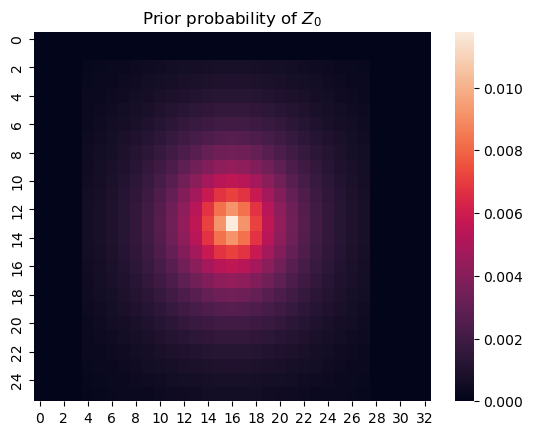

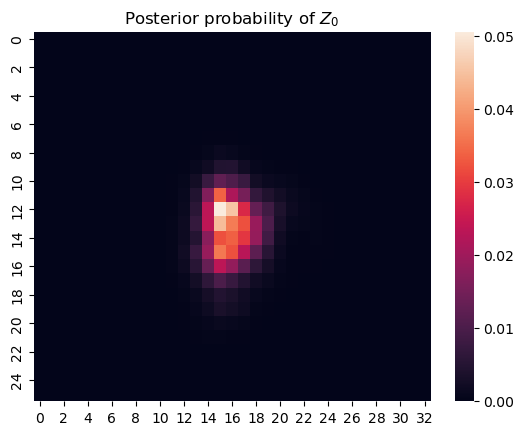

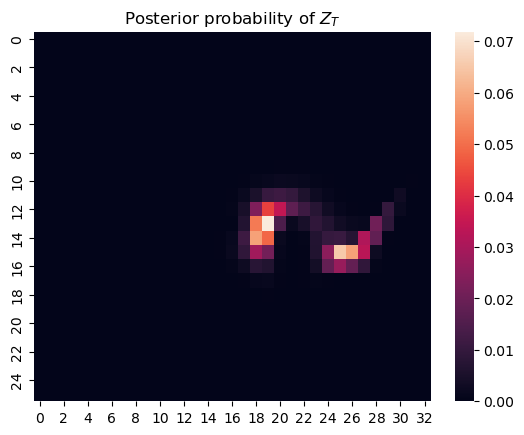

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
_ = sns.heatmap(np.rot90(initial_dist_K.reshape((33, 26))))
_ = plt.title('Prior probability of $Z_0$')
plt.show()

_ = sns.heatmap(np.rot90(posterior_Z_0.reshape((33, 26))))
_ = plt.title('Posterior probability of $Z_0$')
plt.show()

_ = sns.heatmap(np.rot90(posterior_Z_T.reshape((33, 26))))
_ = plt.title('Posterior probability of $Z_T$')


## Question 8 [Code] (10pts) 

Finally, write code to compute the following probability:

$$P(S = s \mid \boldsymbol{x}_{1:T})$$

which is our posterior over what scenario actually befell the _Scorpion_.

- Your existing code should already be able to compute this. **Re-use your existing code** with as few modifications as possible.

- In the space below, compute `posterior_S`, and then run the visualization code. 

- Make sure the indices of `posterior_S` are properly aligned with `prior_S`.

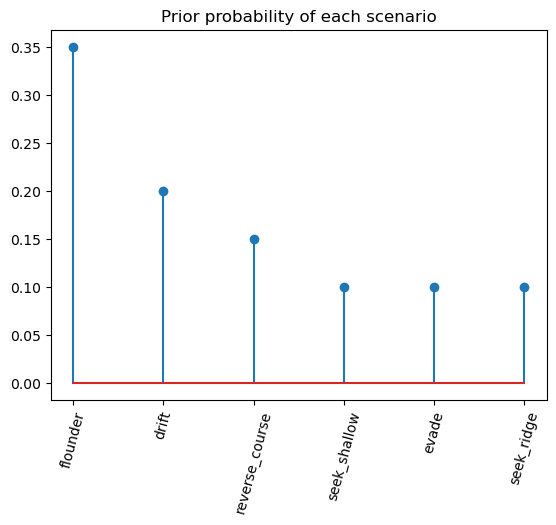

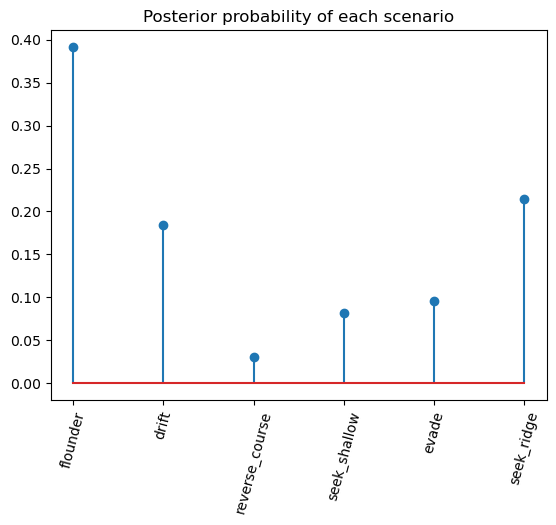

In [18]:
scenarios = df_scenarios['scenario'].values
prior_S = df_scenarios['p(s)'].values

# 'scenario_probabilities' were calculated in question 7's code
posterior_S = scenario_probabilities/np.sum(scenario_probabilities)

assert posterior_S.shape == prior_S.shape and np.allclose(posterior_S.sum(), 1)

# _ = plt.stem(scenarios, prior_S, use_line_collection=True)
_ = plt.stem(scenarios, prior_S)
_ = plt.xticks(rotation=75)
plt.title('Prior probability of each scenario')
plt.show()

# _ = plt.stem(scenarios, posterior_S, use_line_collection=True)
_ = plt.stem(scenarios, posterior_S)
_ = plt.xticks(rotation=75)
plt.title('Posterior probability of each scenario')
plt.show()